# Chihuahua or Muffin
This notebook demonstrates how we can use Pytorch to work on an image classification problem. It's designed to be run in colab

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy

In [2]:
!python --version

Python 3.10.12


In [12]:
#from google.colab import drive
#drive.mount('/content/drive')



/content
sample_data


# prepare directory and files in colab

In [13]:

%cd /content
!git clone https://github.com/porrameth/teach_ai.git
!ls
%cd /content/teach_ai
!ls

/content
Cloning into 'teach_ai'...
remote: Enumerating objects: 1848, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1848 (delta 1), reused 20 (delta 1), pack-reused 1826 (from 1)
Receiving objects: 100% (1848/1848), 156.36 MiB | 41.98 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (1822/1822), done.
sample_data  teach_ai
/content/teach_ai
chihuahua_muffin_resnet01_simple.ipynb	chihuahua_muffin_small2


In [14]:
%pwd
#%cd CodeProj2/02_Learn/pytorch/
#!ls chihuahua_muffin/
!ls chihuahua_muffin_small2/


mytest	train  val


# dataset and loader

In [15]:

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize(255),  # Adjust size as needed  255
    transforms.CenterCrop(224),  # Adjust size as needed 224
    transforms.RandomHorizontalFlip(), # just try
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
TRAIN ='chihuahua_muffin_small2/train'
VAL = 'chihuahua_muffin_small2/val'
TEST = 'chihuahua_muffin_small2/mytest'
# Create dataset
train_data = datasets.ImageFolder(root= TRAIN, transform=transform)
val_data = datasets.ImageFolder(root= VAL ,transform=transform)
test_data = datasets.ImageFolder(root= TEST  ,transform=transform)



In [16]:
#classes = train_data.classes
#classes
val_data.classes
val_data.class_to_idx

{'chihuahua': 0, 'muffin': 1}

In [17]:
val_data.samples[-10:]

[('chihuahua_muffin_small2/val/muffin/img_4_956.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_960.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_971.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_972.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_978.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_979.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_989.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_991.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_996.jpg', 1),
 ('chihuahua_muffin_small2/val/muffin/img_4_997.jpg', 1)]

In [18]:
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size,num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=batch_size,num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,num_workers=2)


In [19]:
len(train_dataloader)
val_dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 925
    Root location: chihuahua_muffin_small2/val
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [20]:
for X, y in val_dataloader:
    print(f' {X.shape}')
    print(f'shape of y {y.shape} {y.dtype} ')
    break

 torch.Size([128, 3, 224, 224])
shape of y torch.Size([128]) torch.int64 


torch.Size([3, 224, 224])


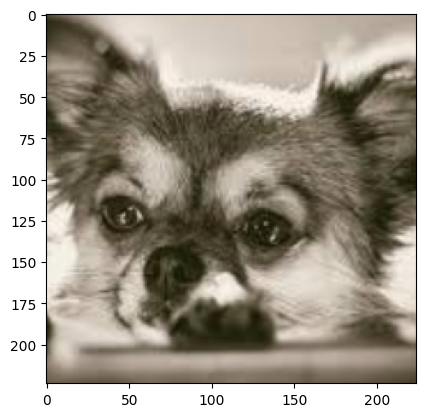

In [21]:
img, lab = train_data[1]
print(img.shape)
lab
## plot 3 channels image- need to permute channel to the last dimension
img = img/2 +.5
plt.imshow((img.permute(1,2,0) * 255).numpy().astype('uint16'))


size 798


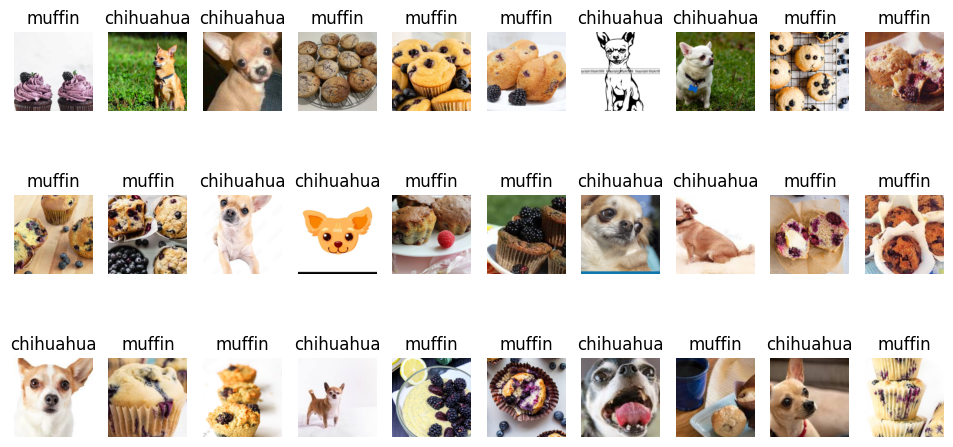

In [22]:
# print sample of data
#import warnings
#warnings.filterwarnings('ignore', message='not allowed')
import random
#img , label = train_data[0]
#print(img.shape, label)


labels = [
   "chihuahua","muffin"
]

row,col=3,10
fig, ax = plt.subplots(row,col,figsize=(12,6))
counter=0
size = len(train_data)
print(f'size {size}')
nums = random.sample(range(size),row*col)
#print(f'nums {nums}')
for r in range(row):
    for c in range(col):

        num  = nums[counter]
        img , lab = train_data[num]
        img= img/2+.5
        img_permute = img.permute(1,2,0)
        img_permute = (img_permute*255).numpy().astype('uint16')
        ax[r,c].imshow(img_permute)
        ax[r,c].set_axis_off()

        #title = "("+str(lab)+")"
        ax[r,c].set_title(labels[lab])
        counter+=1


# Model Architecture

we are using a technique called transfer-learning in order to increase accuracy and speed up the training time

In [23]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    #else "mps"
    #if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#Pre-trained ResNet Model
model = models.resnet50(weights=True)
model = model.to(device)

# Freeze Base Model Parameters
for param in model.parameters():
    param.requires_grad = False

# Replace Final Classifier Layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification
#print(model)

Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [24]:
i = 0
for batch, (xx,yy) in enumerate(val_dataloader):
    print(batch, xx.shape,yy.shape)
    i+=1
    if i == 3:
        break

0 torch.Size([128, 3, 224, 224]) torch.Size([128])
1 torch.Size([128, 3, 224, 224]) torch.Size([128])
2 torch.Size([128, 3, 224, 224]) torch.Size([128])


In [25]:
## Method 2
#loss_fn = nn.BCEWithLogitsLoss()

learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train_one_epoch(epoch_index, tb_writer,training_loader):
    running_loss = 0.
    last_loss = 0.
    #print(f'device = {device}')
    # we use enumerate(training_loader) instead of iter(training_loader) so that we can track the batch index
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #labels= labels.unsqueeze(1).float() ## FOR BCELoss
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        #model = model.to(device)
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 5 == 0:
            last_loss = running_loss / 5 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss



In [27]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 9

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # gradient is on
    model =model.to(device)
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer,train_dataloader)


    running_vloss = 0.0
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    correct=0
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):

            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            #vlabels = vlabels.unsqueeze(1).float() ## For BCELoss
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += (voutputs.argmax(1) == vlabels).type(torch.float).sum().item()

    avg_vloss = running_vloss / (i + 1)
    print(f'--correct = {correct}, validation size ={len(val_dataloader.dataset)}')
    correct /= len(val_dataloader.dataset)
    val_accuracy = 100*correct
    print(f'LOSS train {avg_loss} valid {avg_vloss:>8f}  Val Accuracy {(val_accuracy):>0.4f}% ')
    #print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {avg_vloss:>8f} \n")


    #test(test_dataloader,model, loss_fn)
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best loss, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}_{:.0f}'.format(timestamp, epoch_number,round(val_accuracy,2)*100)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  batch 1 loss: 0.11334879398345947


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  batch 6 loss: 2.277935317158699
--correct = 582.0, validation size =925
LOSS train 2.277935317158699 valid 0.617303  Val Accuracy 62.9189% 
EPOCH 2:
  batch 1 loss: 0.20207998752593995
  batch 6 loss: 0.7085300177335739
--correct = 502.0, validation size =925
LOSS train 0.7085300177335739 valid 1.042266  Val Accuracy 54.2703% 
EPOCH 3:
  batch 1 loss: 0.5611846446990967
  batch 6 loss: 1.0455456137657166
--correct = 759.0, validation size =925
LOSS train 1.0455456137657166 valid 0.540126  Val Accuracy 82.0541% 
EPOCH 4:
  batch 1 loss: 0.17885613441467285
  batch 6 loss: 0.9414741516113281
--correct = 834.0, validation size =925
LOSS train 0.9414741516113281 valid 0.513822  Val Accuracy 90.1622% 
EPOCH 5:
  batch 1 loss: 0.1498378872871399
  batch 6 loss: 0.6083517432212829
--correct = 508.0, validation size =925
LOSS train 0.6083517432212829 valid 0.549056  Val Accuracy 54.9189% 
EPOCH 6:
  batch 1 loss: 0.305928111076355
  batch 6 loss: 0.7567242085933685
--correct = 723.0, validat

In [28]:
!ls -l

total 645912
-rw-r--r-- 1 root root   771897 Aug 16 09:10 chihuahua_muffin_resnet01_simple.ipynb
drwxr-xr-x 5 root root     4096 Aug 16 09:10 chihuahua_muffin_small2
-rw-r--r-- 1 root root 94372998 Aug 16 09:12 model_20240816_091207_0_6292
-rw-r--r-- 1 root root 94372998 Aug 16 09:13 model_20240816_091207_2_8205
-rw-r--r-- 1 root root 94372998 Aug 16 09:13 model_20240816_091207_3_9016
-rw-r--r-- 1 root root 94372998 Aug 16 09:14 model_20240816_091207_5_7816
-rw-r--r-- 1 root root 94372998 Aug 16 09:14 model_20240816_091207_6_9222
-rw-r--r-- 1 root root 94372998 Aug 16 09:15 model_20240816_091207_7_8292
-rw-r--r-- 1 root root 94372998 Aug 16 09:15 model_20240816_091207_8_8735
drwxr-xr-x 3 root root     4096 Aug 16 09:12 runs


In [29]:
#torch.save(model.state_dict(), "model_muffin_weights-resnet-medium.pth")
#torch.save(model.state_dict(), "model_muffin_weights-resnet-big.pth")
torch.save(model.state_dict(), "model_muffin_weights-resnet-small2.pth")


#torch.save(model.state_dict(), "model_muffin-s.pth")
print("Saved PyTorch Model State to model_muffin_weights-resnet-xxxx.pth")

Saved PyTorch Model State to model_muffin_weights-resnet-xxxx.pth


#Load trained model and use it on test set

In [34]:
!ls -l

total 738076
-rw-r--r-- 1 root root   771897 Aug 16 09:10 chihuahua_muffin_resnet01_simple.ipynb
drwxr-xr-x 5 root root     4096 Aug 16 09:10 chihuahua_muffin_small2
-rw-r--r-- 1 root root 94372998 Aug 16 09:12 model_20240816_091207_0_6292
-rw-r--r-- 1 root root 94372998 Aug 16 09:13 model_20240816_091207_2_8205
-rw-r--r-- 1 root root 94372998 Aug 16 09:13 model_20240816_091207_3_9016
-rw-r--r-- 1 root root 94372998 Aug 16 09:14 model_20240816_091207_5_7816
-rw-r--r-- 1 root root 94372998 Aug 16 09:14 model_20240816_091207_6_9222
-rw-r--r-- 1 root root 94372998 Aug 16 09:15 model_20240816_091207_7_8292
-rw-r--r-- 1 root root 94372998 Aug 16 09:15 model_20240816_091207_8_8735
-rw-r--r-- 1 root root 94374942 Aug 16 09:16 model_muffin_weights-resnet-small2.pth
drwxr-xr-x 3 root root     4096 Aug 16 09:12 runs


In [35]:
#model = Convo().to(device)
model1 = models.resnet50(weights =False)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 2)
#model1.load_state_dict(torch.load("model_muffin_weights-resnet.pth"))
#model1.load_state_dict(torch.load("model_muffin_weights-resnet-big.pth"))
#model1.load_state_dict(torch.load("model_muffin_weights-resnet-medium.pth"))
model1.load_state_dict(torch.load("model_muffin_weights-resnet-small2.pth"))
#model1.load_state_dict(torch.load("model_20240816_091207_8_8735"))
model1.to(device)
model1.eval()
print("Model loaded")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded


In [37]:
def sample_incorrect_images(dataset):
    row,col=2,5
    counter=0

    if len(dataset) >= row*col:
        nums = random.sample(range(len(dataset)),row*col)
        fig, ax = plt.subplots(row,col,figsize=(12,6))
        for r in range(row):
            for c in range(col):
                #print(f'counter = {counter}')
                num = nums[counter]
                img , lab, pred = dataset[num]
                img = img.to('cpu')
                img = img/2 +.5
                img_permute = img.permute(1,2,0)
                img_permute = (img_permute*255).numpy().astype('uint16')
                ax[r,c].imshow(img_permute)
                ax[r,c].set_axis_off()

                #title = "("+str(lab)+")"
                ax[r,c].set_title(f'Pred:{labels[pred]}\nActual:{labels[lab]}')
                counter+=1
    else:
        print(f'Else: length of incorrect dataset = {len(dataset)}')
        fig, ax = plt.subplots(len(dataset),figsize=(15,8))
        for idx, data in enumerate(dataset):
            #print(f'idx={idx}')
            img, lab, pred = data
            img = img.to('cpu')
            img = img/2 +.5
            img_permute = img.permute(1,2,0)
            img_permute = (img_permute*255).numpy().astype('uint16')
            ax[idx].imshow(img_permute)
            ax[idx].set_axis_off()
                #title = "("+str(lab)+")"
            ax[idx].set_title(f'Pred:{labels[pred]}\nActual:{labels[lab]}')




def test_testset(model=model1, dataloader=test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    incorrect_preds = []
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            #target = target.unsqueeze(1).float() ## for BCELoss
            output = model(data)
            #output = output.unsqueeze(1).float()
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for idx in range(len(data)):
                if pred[idx] != target[idx]:
                    incorrect_preds.append((data[idx], target[idx], pred[idx]))



    test_loss /= len(dataloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))
    if len(incorrect_preds) > 0:
      sample_incorrect_images(incorrect_preds)

In [38]:
#test_testset(model=model)


Test set: Average loss: 0.0039, Accuracy: 95/98 (97%)

Else: length of incorrect dataset = 3


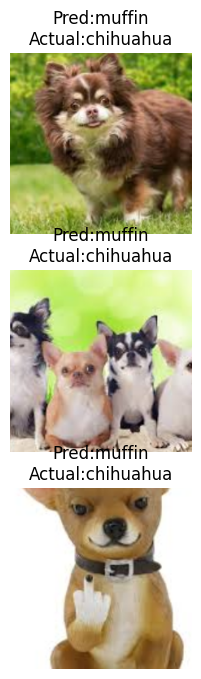

In [39]:
test_testset()

In [ ]:
test_data[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
test_data[0][1]

0